In [59]:
import urllib.request
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.linear_model import LinearRegression

# Download the data
url = f"https://downloads.psl.noaa.gov/Datasets/ghcncams/air.mon.mean.nc"
savename = url.split("/")[-1]
urllib.request.urlretrieve(url, savename)

ds = xr.load_dataset(savename)

Question 1

In [60]:
#extract the air temperature dataset and transform the temperature to celsius
air = ds.air - 273.15
air = air.sel(time=slice("1990-01-01", "2020-12-01")) #select specific years
air = air.resample(time="Y").mean() #resample to years instead of months

#create weights
weights = np.cos(np.deg2rad(air.lat))
weights.name = "weights"

#weight the temperatures
air_weighted = air.weighted(weights)

#find the weighted mean
weighted_mean = air_weighted.mean(("lon", "lat"))
weighted_mean

#unweighted mean
air.mean(("lon", "lat"))

/usr/local/lib/python3.11/dist-packages/xarray/groupers.py:487: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


Question 2

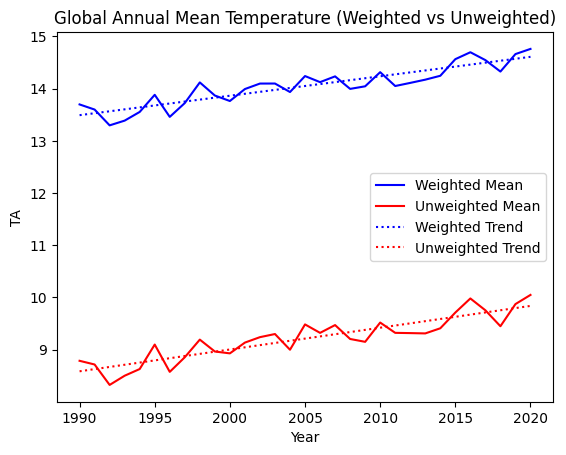

In [29]:
#find x variable
years = weighted_mean['time'].dt.year.values
years = years.reshape(-1, 1)

#assign unweighted mean to a variable
unweighted_mean = air.mean(('lon', 'lat'))

#fit a linear regression model to the weighted temps
weighted_temp = weighted_mean.values
reg_weighted = LinearRegression().fit(years, weighted_temp)
weighted_trend = reg_weighted.predict(years)

#fit a linear regression model to the unweighted temps
unweighted_temp = unweighted_mean.values
reg_unweighted = LinearRegression().fit(years, unweighted_temp)
unweighted_trend = reg_unweighted.predict(years)

#plot the weighted and unweighted means
plt.plot(years, weighted_temp, label='Weighted Mean', color='blue', linestyle='-')
plt.plot(years, unweighted_temp, label='Unweighted Mean', color='red', linestyle='-')

#plot the trend lines
plt.plot(years, weighted_trend, label='Weighted Trend', color='blue', linestyle=':')
plt.plot(years, unweighted_trend, label='Unweighted Trend', color='red', linestyle=':')

#add a title and labels
plt.xlabel('Year')
plt.ylabel('TA')
plt.title('Global Annual Mean Temperature (Weighted vs Unweighted)')
plt.legend()

plt.show()

Question 3

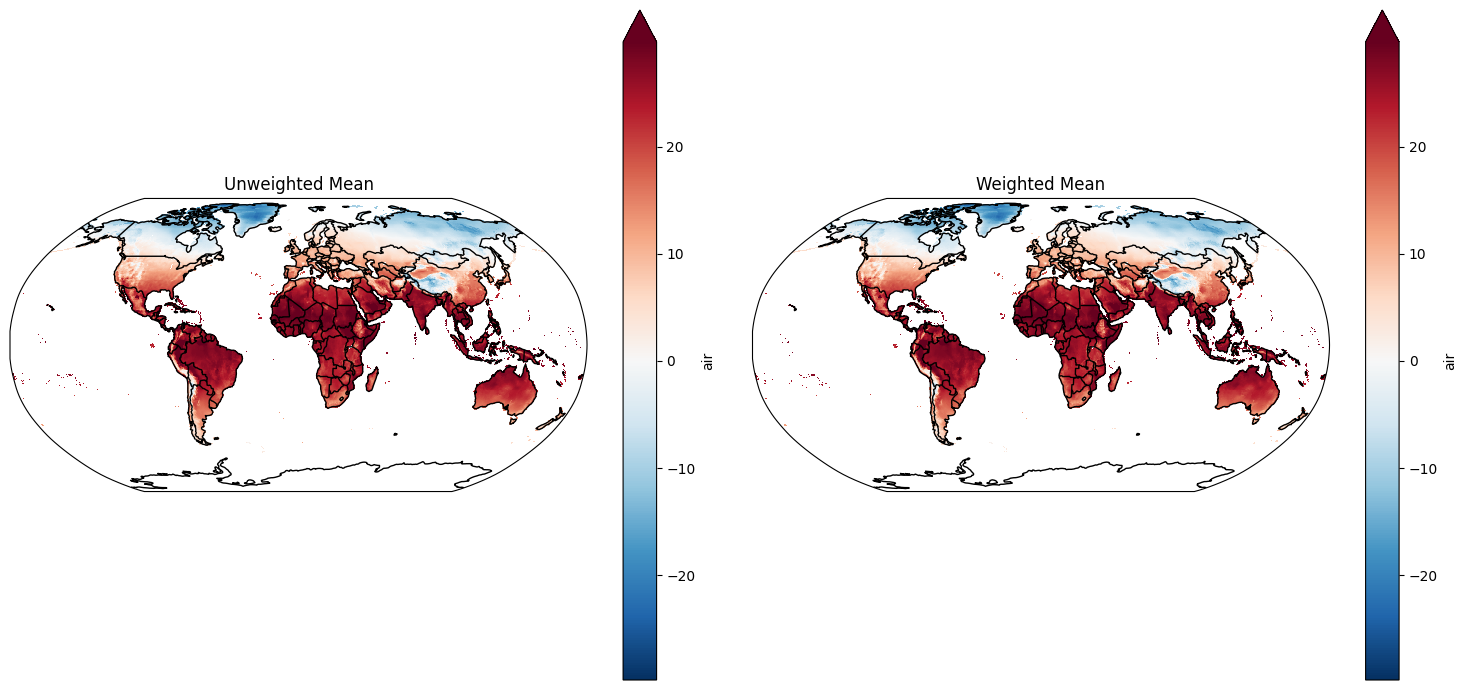

In [70]:
#set up the plot layout and define the projections
fig, axs = plt.subplots(1, 2, figsize=(15, 7), subplot_kw={'projection': ccrs.Robinson()})

#plot the unweighted mean
p1 = air.mean(dim="time").plot(
    ax=axs[0],  #Plot on the first axis
    transform=ccrs.PlateCarree(),
    robust=True
)

axs[0].coastlines()  # Add coastlines to the first plot
axs[0].add_feature(cfeature.BORDERS)  #Add borders to the first plot
axs[0].set_title("Unweighted Mean")

#plot the weighted mean
p2 = air_weighted.mean(dim="time").plot(
    ax=axs[1],  #Plot on the second axis
    transform=ccrs.PlateCarree(),
    robust=True
)

axs[1].coastlines()  #Add coastlines to the second plot
axs[1].add_feature(cfeature.BORDERS)  #Add borders to the second plot
axs[1].set_title("Weighted Mean")

plt.tight_layout()
plt.show()